## Übung zu Praktische Optimierung, SoSe 2024
Dr. Marco Pleines
## Template zu Präsenzblatt 8

## Latin hypercube design und Kriging

**Erklären Sie *Latin Hypercube Sampling* (LHS) kurz in eigenen Worten.**

LHS generiert n Samples --> Siehe scipy dokumentation, https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.qmc.LatinHypercube.html#scipy.stats.qmc.LatinHypercube

**Verwenden Sie folgende Zielfunktion:**
$$f(x, y) = x^2 + y^2 + 10\cos(xy), \quad x, y \in [-10, 10].$$

In [19]:
import numpy as np
import sklearn

LOWER, UPPER = -10, 10

def f(x):
    return x[0]**2 + x[1]**2 + 10*np.cos(x[0]*x[1])

**Für das Kriging-Modell soll die Funktion `GaussianProcessRegressor` aus dem Paket *sklearn.gaussian_process* ausschließlich mit Defaultwerten verwendet werden (obwohl hier eine Optimierung der Parameter prinzipiell sinnvoll sein könnte)**

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor

def make_kriging_model(X, y):
        
    # Kriging mit default-Einstellungen
    model = GaussianProcessRegressor()

    # Modell an die Daten anpassen
    model.fit(X, y)

    return model

**Nutzen Sie die Implementierungen `qmc.LatinHypercube` aus dem Paket *scipy.stats*. Implementieren Sie die vier Varianten `centered`, `scramble`, `random-cd` und `lloyd`. Achten Sie darauf, dass die gezogenen Samples den gesamten Definitionsbereich abdecken.**

**Vergleichen Sie Ihre Ergebnisse mit den Ergebnissen, die für ein $7$$\times$$7$-Gitter, eine gleichverteilte Stichprobe und eine zentrierte normalverteilte Stichprobe mit Standardabweichung $\sigma=10$ (in allen Dimensionen) erzielt werden.**

In [29]:
# Abstaststellen erstellen
from scipy.stats import qmc

DIM = 2
N = 7

# Gleichverteilung
def uniform():
    return np.random.uniform(LOWER, UPPER, (N**DIM, DIM))

# LHD-scrambled
def LHD_scrambled():
    sampler = qmc.LatinHypercube(d=DIM,scramble=True)
    samples=sampler.random(n=N**DIM)
    return qmc.scale(samples,LOWER,UPPER)

# LHD-centered
def LHD_centered():
    sampler=qmc.LatinHypercube(d=DIM,scramble=False)
    samples=sampler.random(n=N**DIM)
    return qmc.scale(samples,LOWER,UPPER)

# LHD-random-cd
def LHD_random_cd():
    sampler=qmc.LatinHypercube(d=DIM,optimization='random-cd')
    samples=sampler.random(n=N**DIM)
    return qmc.scale(samples,LOWER,UPPER)

# LHD-lloyd
def LHD_lloyd():
    sampler=qmc.LatinHypercube(d=DIM,optimization='lloyd')
    samples=sampler.random(n=N**DIM)
    return qmc.scale(samples,LOWER,UPPER)

# Gitter
def grid():
    samples=np.linspace(LOWER,UPPER,num=N)
    samples=np.array(np.meshgrid(samples,samples))
    return np.transpose([samples[0].ravel(),samples[1].ravel()])

# Normalverteilung
def mnorm():
    return np.random.multivariate_normal(mean=np.zeros(DIM),cov=np.identity(DIM)*10,size=N**DIM) 

In [23]:
# Test
X = grid()
y = np.apply_along_axis(f, axis=1, arr=X)

new_x = np.linspace(LOWER, UPPER, num=201)
new_X = np.array(np.meshgrid(new_x, new_x))
true_y = np.apply_along_axis(f, axis=0, arr=new_X)

model = make_kriging_model(X, y)


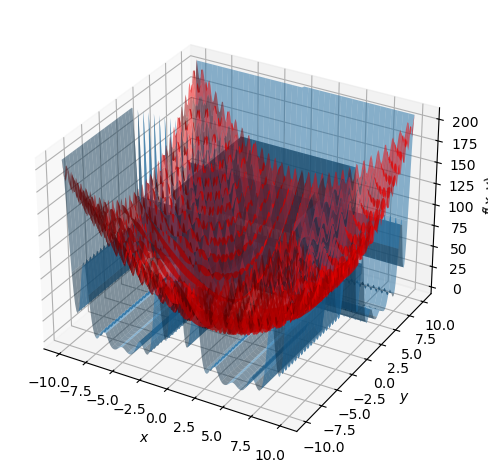

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3D-Visualisierung
ax = plt.figure().add_subplot(projection="3d")

preds = model.predict(new_X.reshape(-1,2)).reshape(len(new_X[0]), -1)
ax.plot_surface(new_X[0], new_X[1], preds,
                label="kriging", alpha=0.5)

ax.plot_surface(new_X[0], new_X[1], true_y,
                label="true", color="red", alpha=0.5)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$f(x,y)$")

#ax.set_zlim((-80, 20))

# change view angle
#ax.view_init(azim=35, elev=25)
#ax.view_init(azim=0, elev=0)
#ax.view_init(azim=90, elev=0)


plt.tight_layout()
plt.show()

**Bilden Sie ein Kriging-Modell. Nutzen Sie das Kriging-Modell, um eine Vorhersage auf einem Gitter mit jeweils 201 äquidistanten Punkten pro Dimension zu erstellen. Berechnen Sie aus den Vorhersagen den mittleren absoluten Abstand zur Wahrheit. Messen Sie auch die Zeit, die im Durchschnitt pro Wiederholung benötigt wird und interpretieren Sie die Ergebnisse.**

In [30]:
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm
from time import time as now

new_x = np.linspace(LOWER, UPPER, num=201)
new_X = np.array(np.meshgrid(new_x, new_x))
true_y = np.apply_along_axis(f, axis=0, arr=new_X)

# 10x alle Modelle anpassen
results = {}
times = {}

def repeat(sampler, results, repeat=20):
    key = sampler.__name__
    results[key] = []
    start_time = now()
    for _ in range(repeat):
        samples = sampler()
        m = make_kriging_model(samples, np.apply_along_axis(f, axis=1, arr=X))
        mae = mean_absolute_error(
            m.predict(new_X.reshape(-1,2)),
            true_y.reshape(-1))
        results[key].append(mae)
    time = (now() - start_time)*1000 / repeat
    return time

for sampler in tqdm([
        LHD_scrambled,
        LHD_centered,
        LHD_random_cd,
        LHD_lloyd,
        grid,
        mnorm,
        uniform
    ]):
    time = repeat(sampler, results)
    times[sampler.__name__] = time

  0%|          | 0/7 [00:00<?, ?it/s]

,Time [ms]
uniform,96.884441
mnorm,98.485184
grid,102.023637
LHD_centered,103.869820
LHD_scrambled,124.684989
LHD_lloyd,135.810292
LHD_random_cd,706.642783


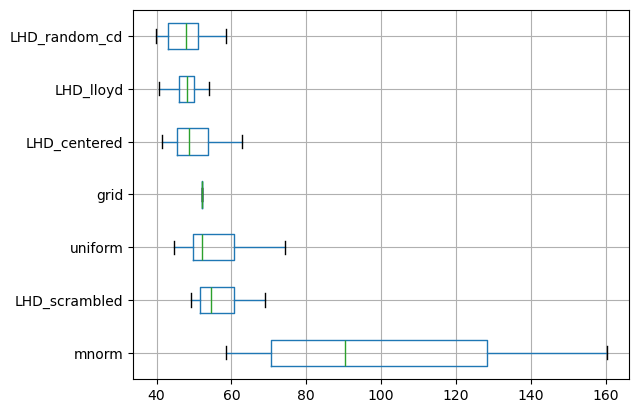

In [31]:
# Boxplots
import pandas as pd

df_times = pd.DataFrame.from_dict(times, orient='index', columns=['Time [ms]'])\
                                                    .sort_values(by='Time [ms]')

df_results = pd.DataFrame(results)
df_results = df_results[df_results.median().sort_values(ascending=False).index]

display(df_times)
_ = df_results.boxplot(vert=False, showfliers=False)

Alle LHS Methoden sind besser als normalverteilte Werte